# 5. Decision Trees
In this lab, we will learn a popular machine learning algorithm, Decision Trees. 
We will show how to use Decision Trees to do classification tasks on the Digits Dataset.
The first showcase is to call the sklearn library to do the classification task on the Digits Dataset.
Then we will code the Decision Trees from scratch to understand how it works under the hood.
Lastly, to wrap up this lab, you need to convert the code into a regression task on the airfoil dataset.
This lab is due by the end of this week Mar 15.

## 5.1 Classification Task on Digits Dataset
The Digits dataset is a dataset of handwritten digits. Each feature is the intensity of one pixel of an 8 x 8 image. The target is the digit itself. We will use the Decision Trees to classify the digits.


In [3]:
import pandas as pd

X_train = pd.read_csv('datasets/digits/Digits_X_train.csv').values
y_train = pd.read_csv('datasets/digits/Digits_y_train.csv').values
X_test  = pd.read_csv('datasets/digits/Digits_X_test.csv').values
y_test  = pd.read_csv('datasets/digits/Digits_y_test.csv').values

Note that each data can be reshaped into an 8 x 8 image and visualized using the following code.


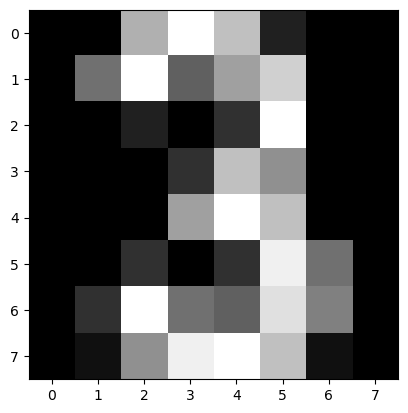

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(8, 8), cmap='gray')
plt.show()

Now, let's use the Decision Trees to classify the digits.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8577777777777778


## 5.2 Decision Trees from Scratch
Here, we will only use numpy to code the Decision Trees from scratch. 

In [4]:
import numpy as np

# define the accuracy function
def accuracy(ypred, ytrue):
    return np.sum(ypred==ytrue)/float(len(ypred))

Now, this is the object of the Decision Trees.

In [7]:
class decisiontree():
    def __init__(self, max_depth=5, current_depth=0, max_features=None):
        # tree structure value
        self.left_tree = None
        self.right_tree = None
        self.max_depth = max_depth
        self.current_depth = current_depth

        self.best_feature_id = 0.
        self.best_gain = 0.
        self.best_split_value = 0.
        self.GINI = 0.
        self.label = None

        # feature values
        self.X = None
        self.y = None
        self.M = 0
        self.N = 0

        self.max_features = max_features

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.M = X.shape[0]
        self.N = X.shape[1]

        if self.max_features==None or self.max_features>self.N:
            self.max_features = self.N
        if self.current_depth < self.max_depth:
            self.GINI = self.GINI_calculation(self.y)
            self.best_feature_id, self.best_gain, self.best_split_value = self.find_best_split()
            if self.best_gain > 0.:
                self.split_trees()

    def split_trees(self):
        self.left_tree = decisiontree(max_depth=self.max_depth, current_depth=self.current_depth+1)
        self.right_tree = decisiontree(max_depth=self.max_depth, current_depth=self.current_depth+1)
        best_feature_values = self.X[:, self.best_feature_id]
        left_indices = np.where(best_feature_values < self.best_split_value)
        right_indices = np.where(best_feature_values >= self.best_split_value)

        left_tree_X = self.X[left_indices]
        left_tree_y = self.y[left_indices]
        right_tree_X = self.X[right_indices]
        right_tree_y = self.y[right_indices]

        self.left_tree.fit(left_tree_X, left_tree_y)
        self.right_tree.fit(right_tree_X, right_tree_y)

    def GINI_calculation(self, y):
        if y.size==0 or y is None:
            return 0.
        unique, counts = np.unique(y, return_counts=True)
        prob = counts/y.size
        return 1.-np.sum(prob*prob)

    def find_best_split(self):
        best_feature_id  = None
        best_gain        = 0.
        best_split_value = None
        n_features = np.random.choice(self.N, self.max_features, replace=False)
        for feature_id in n_features:
            current_gain, current_split_value = self.find_best_split_one_feature(feature_id)
            if best_gain < current_gain:
                best_feature_id = feature_id
                best_gain = current_gain
                best_split_value = current_split_value
        return best_feature_id, best_gain, best_split_value

    def find_best_split_one_feature(self, feature_id):
        feature_values = self.X[:, feature_id]
        unique_feature_values = np.unique(feature_values)
        best_gain = 0.
        best_split_value = None

        if len(unique_feature_values) == 1:
            return best_gain, best_split_value
        for fea_val in unique_feature_values:
            left_indices = np.where(feature_values < fea_val)
            right_indices = np.where(feature_values >= fea_val)

            left_tree_X = self.X[left_indices]
            left_tree_y = self.y[left_indices]

            right_tree_X = self.X[right_indices]
            right_tree_y = self.y[right_indices]

            left_GINI = self.GINI_calculation(left_tree_y)
            right_GINI = self.GINI_calculation(right_tree_y)

            left_n = left_tree_X.shape[0]
            right_n = right_tree_X.shape[0]

            current_gain = self.GINI-left_n/self.M*left_GINI-right_n/self.M*right_GINI
            if best_gain < current_gain:
                best_gain = current_gain
                best_split_value = fea_val
        return best_gain, best_split_value

    def predict(self, X_test):
        n_test = X_test.shape[0]
        y_pred = np.empty(n_test, dtype=int)
        for i in range(n_test):
            y_pred[i] = self.tree_propogation(X_test[i])
        return y_pred

    def tree_propogation(self, feature):
        # this is a leaf
        if self.left_tree is None:
            return self.predict_label()
        # belongs to the left tree
        if feature[self.best_feature_id] < self.best_split_value:
            return self.left_tree.tree_propogation(feature)
        # belongs to the right tree
        else:
            return self.right_tree.tree_propogation(feature)

    def predict_label(self):
        if self.label != None:
            return self.label
        unique, counts = np.unique(self.y, return_counts=True)
        max_count = 0
        #idx = np.argmax(counts)
        #self.label = unique[idx]
        for i in range(unique.size):
            if counts[i] > max_count:
                max_count = counts[i]
                self.label = unique[i]
        return self.label

Now, let's use the Decision Trees to classify the digits.

In [13]:
DT = decisiontree(max_depth=5)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
print(accuracy(y_pred, y_test.ravel()))

0.6622222222222223


## 5.3 Regression Task on Airfoil Dataset
The Airfoil dataset is a dataset of airfoil self-noise. Each feature is a physical attribute of the airfoil. The target is the scaled sound pressure level. We will use the Decision Trees to do the regression task on the Airfoil dataset.

In [12]:
import pandas as pd

X_train = pd.read_csv('datasets/airfoil/airfoil_self_noise_X_train.csv').values
y_train = pd.read_csv('datasets/airfoil/airfoil_self_noise_y_train.csv').values
X_test  = pd.read_csv('datasets/airfoil/airfoil_self_noise_X_test.csv').values
y_test  = pd.read_csv('datasets/airfoil/airfoil_self_noise_y_test.csv').values

Now, think about how to convert the classification task into a regression task. You need to modify the code in 5.2 to do the regression task on the Airfoil dataset. Using the following to test. This will be a hard one!


In [23]:
def RMSE(ypred, ytrue):
    return np.sqrt(np.sum((ypred-ytrue)**2)/ypred.shape[0])


import numpy as np

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left  # Left child (subtree)
        self.right = right  # Right child (subtree)
        self.value = value  # Value of the node for leaf nodes (average of target values)

To submit this lab, you need to work on this jupyter notebook directly and submit this file to your repo.

In [24]:
class my_DecisionTreeReg:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if depth == self.max_depth or num_samples <= 1:
            return Node(value=np.mean(y))

        # Find the best split
        best_feature_index, best_threshold = self._find_best_split(X, y)

        # Split the data
        left_indices = np.where(X[:, best_feature_index] <= best_threshold)[0]
        right_indices = np.where(X[:, best_feature_index] > best_threshold)[0]

        # Recursively build left and right subtrees
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature_index=best_feature_index, threshold=best_threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_mse = float('inf') #used to keep track of the best mean MSE found during the split search.
        best_feature_index = None #store the index of the best feature found for splitting the data
        best_threshold = None #store the threshold value of the best split found

        for feature_index in range(num_features):#loops over every feature in the data set 
            thresholds = np.unique(X[:, feature_index])#computes unique threshold values for the current feature

            for threshold in thresholds:#loop iterates over each unique threshold value for the current feature
                # computes the indices of samples where the feature value is <= threshold
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0] # greater than the threshold

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue #skip the rest of the loop iteration n move to nxt threshold
                
                
                left_y = y[left_indices]
                right_y = y[right_indices]

                mse = self._mse(left_y) + self._mse(right_y)
                if mse < best_mse:
                    best_mse = mse
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.root) for x in X])

    def _predict_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._predict_tree(x, node.left)
        else:
            return self._predict_tree(x, node.right)

### Using our regressor and comparing the  performance with the sklearn one

In [29]:
#DT = decisiontree()
DT = my_DecisionTreeReg(max_depth=25)
DT.fit(X_train, y_train)

y_pred = DT.predict(X_test)
print(RMSE(y_pred, y_test.ravel()))

from sklearn.tree import DecisionTreeRegressor
skDT = DecisionTreeRegressor()
skDT.fit(X_train, y_train)
y_pred = skDT.predict(X_test)
print(RMSE(y_pred, y_test.ravel()))

0.6354358460158124
0.5020910314349234


### I will also try training with other depth

In [30]:
# Fit the decision tree regressor
tree_reg = my_DecisionTreeReg(max_depth=5)
tree_reg.fit(X_train, y_train)

# Make predictions
y_pred_train = tree_reg.predict(X_train)
y_pred_test = tree_reg.predict(X_test)

# Compute evaluation metrics
mse_train = RMSE(y_train, y_pred_train)# Using the accuracy method that we defined earlier
mse_test = RMSE(y_test, y_pred_test)


print("Training Set:")
print("MSE: {:.4f}".format(mse_train))
print("Testing Set:")
print("MSE: {:.4f}".format(mse_test))

Training Set:
MSE: 0.8709
Testing Set:
MSE: 0.7354


### On this part onwards I will try to see if I can trace with a plot how the regressor  predicted.
I know this might be wrong but i did it just for quriosity 

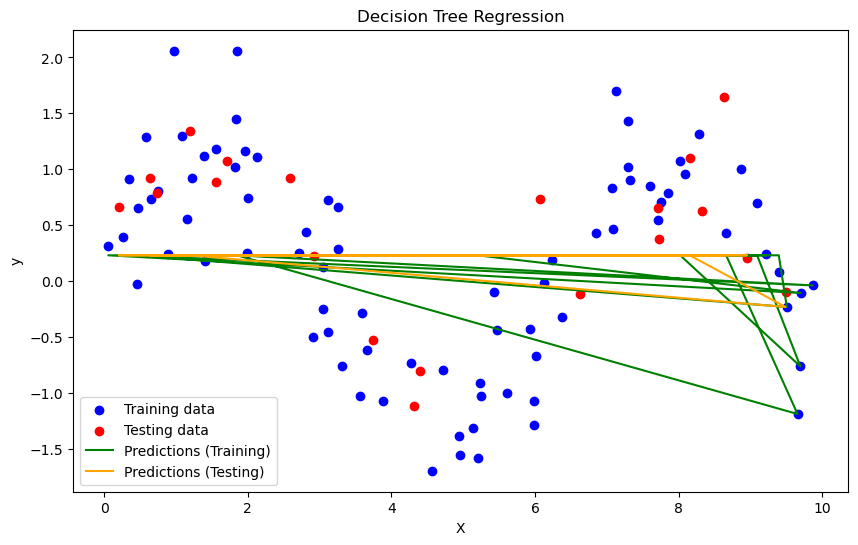

In [33]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c='blue', label='Training data')
plt.scatter(X_test, y_test, c='red', label='Testing data')
plt.plot(X_train, y_pred_train, c='green', label='Predictions (Training)')
plt.plot(X_test, y_pred_test, c='orange', label='Predictions (Testing)')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

# Here I will try and use other accuracy measures for sklearn and compare

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute predictions
y_pred_train = tree_reg.predict(X_train)
y_pred_test = tree_reg.predict(X_test)

# Compute evaluation metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Training Set:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(mse_train, rmse_train, mae_train, r2_train))
print("Testing Set:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(mse_test, rmse_test, mae_test, r2_test))


Training Set:
MSE: 0.7585, RMSE: 0.8709, MAE: 0.6972, R2: 0.0508
Testing Set:
MSE: 0.5408, RMSE: 0.7354, MAE: 0.6198, R2: -0.1137
